In [1]:
tweet_list_obi = list()
tweet_list_tinubu = list()
tweet_list_atiku = list()
tweet_list_kwankwanso = list()

In [2]:
#!pip install textblob
#!pip install wordcloud

,Date,Raw tweet
0,NaN,@Oluwamidas6520 @Canny__Dee @PeterObi He said ...
1,NaN,Do not vote your conscience it's not good enou...
2,NaN,Funny! A man that has NEVER held any DEFINITIV...
3,NaN,"@itzz_blitz1 @PeterObi Yes, that is fine."
4,NaN,@SaharaReporters @YeleSowore @officialABAT @at...
...,...,...
2000,NaN,@stefan_mccauley Dey play o... Who you want ca...
2001,NaN,@gchahal @PeterObi @atiku @officialABAT Peter ...
2002,NaN,@balamiisaac @PeterObi @NgLabour @aburechamber...
2003,NaN,@balamiisaac @PeterObi @NgLabour @aburechamber...


In [36]:
tweet1 = [2, 5, 8, 10, 200]
tweet2 = [5, 8, 9]
tweet1+tweet2

[2, 5, 8, 10, 200, 5, 8, 9]

In [104]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
nltk.download('vader_lexicon')
#import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

#@st.experimental_memo
#peterobi = pd.read_csv('peterobi.csv')
#atiku = pd.read_csv('atiku.csv')
#bat = pd.read_csv('BAT.csv')
import time  # to simulate a real time data, time loop

import numpy as np  # np mean, np random
import pandas as pd  # read csv, df manipulation
import plotly.express as px  # interactive charts
import streamlit as st  # 🎈 data web app development

st.set_page_config(
    page_title="Real-Time Presidential Race Analysis",
    page_icon="✅",
    layout="wide",
)

# dashboard title
st.title("Real-Time / Presidential Race Analysis")

# top-level filters
selected = st.selectbox("Select the Job", index=3, options=["PeterObi", "BAT", "Atiku"])

# creating a single-element container
placeholder = st.empty()

def extract_tweets(keyword1, keyword2, from_date, number_of_tweets_to_retrieve):
    # Importing the libraries
    import configparser
    import tweepy
    import pandas as pd

    # Read the config file
    config = configparser.ConfigParser()
    config.read('config.ini')

    # Read the values
    api_key = config['twitter']['api_key']
    api_key_secret = config['twitter']['api_key_secret']
    access_token = config['twitter']['access_token']
    access_token_secret = config['twitter']['access_token_secret']

    # Authenticate
    auth = tweepy.OAuthHandler(api_key, api_key_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    #For Obi
    tweets = tweepy.Cursor(api.search_tweets, q=keyword1 + " -filter:retweets", lang="en", since_id=from_date, tweet_mode='extended').items(number_of_tweets_to_retrieve)
    tweets_2 = tweepy.Cursor(api.search_tweets, q= keyword2 + " -filter:retweets", lang="en", since_id=from_date, tweet_mode='extended').items(number_of_tweets_to_retrieve)
    tweet1_data = []
    tweet2_data = []
    date = []
    date2 = []
    #print(tweets)
    for tweet1, tweet2 in zip(tweets, tweets_2):
        #print("Tweet:", tweet1.text, "\n Date: ", tweet1.created_at, "\n\n")
        tweet1_data.append(tweet1.full_text)
        tweet2_data.append(tweet2.full_text)
        date.append(tweet1.created_at)
        date2.append(tweet2.created_at)
    new_data = pd.DataFrame(list(zip(date+date2, tweet1_data+tweet2_data)), columns=['Date', 'Raw tweet'])
    existing_data = pd.read_csv(str.lower(keyword1) + '.csv')
    export = existing_data.append(new_data, ignore_index=True)
    export['Raw tweet'].drop_duplicates(inplace = True)
    export.to_csv(str.lower(keyword1) + '.csv', index=False)
    
    return export
    #last_date = date2[len(date2) - 1]
    
def clean_text(keyword1):
    import re
    #Cleaning Text (RT, Punctuation etc)
    #Creating new dataframe and new features
    tw_list = pd.read_csv(str.lower(keyword1) + '.csv')
    tw_list["text"] = tw_list['Raw tweet']
    #Removing RT, Punctuation etc
    #rt = lambda x: re.sub("(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
    #rt = lambda x: re.sub("(@[A-Za-z0–9_]+)|(https?:\/\/[^\s]+)|(@[A-Za-z0–9]+)|([^\x00-\x7F])"," ",x)
    #rt = lambda x: re.sub("(@[A-Za-z0–9_]+)|(https?:\/\/[^\s]+)|(@[A-Za-z0–9]+)|([^\x00-\x7F])|(\n)"," ",x)
    #rt = lambda x: re.sub("(@[A-Za-z0-9_]+)|(https?:\/\/[^\s]+)|(@[A-Za-z0-9_]+)|([^\x00-\x7F])|(\n)"," ",x)
    rt = lambda x: re.sub("(@(?!BAT|Tinubushettima|PeterObi|obidatti|Kwankwanso|Atiku)[A-Za-z0-9_]+)|(https?:\/\/[^\s]+)|([^\x00-\x7F])|(\n)|(\",)", " ", x)
    #rt = lambda x: re.sub("(@[A-Za-z0-9]+)|(https?:\/\/[^\s]+)|([^\x00-\x7F])|(\n)"," ",x)
    tw_list['text'] = tw_list.text.map(rt)
    tw_list['text'] = tw_list['text'].map(lambda x: re.sub(' +', ' ', x))
    tw_list['text'] = tw_list.text.str.lower()
    tw_list['text'] = tw_list['text'].str.replace('dey play o', 'Just keep playing')
    tw_list.head(10)
    
    return tw_list

def sentiment_analysis(keyword1):
# Initialize SentimentIntensityAnalyzer
    df = clean_text(keyword1)
    analyzer = SentimentIntensityAnalyzer()

    # Create a new column 'sentiment' and apply sentiment analysis to 'text' column
    df['sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(x))

    # Create new columns for sentiment scores
    df['neg'] = df['sentiment'].apply(lambda x: x['neg'])
    df['neu'] = df['sentiment'].apply(lambda x: x['neu'])
    df['pos'] = df['sentiment'].apply(lambda x: x['pos'])
    df['compound'] = df['sentiment'].apply(lambda x: x['compound'])
    sentiment_analysis_data = df.copy()
    return sentiment_analysis_data

def plot_sentiments(keyword1):
    sentiment_data = sentiment_analysis(keyword1)
    import matplotlib.pyplot as plt
    sentiment_data['sentiment'] = sentiment_data['compound'].apply(lambda x: 'positive' if x >= 0 else 'negative')

# count the number of positive and negative sentiments
    pos_count = sentiment_data[sentiment_data['sentiment'] == 'positive']['sentiment'].count()
    neg_count = sentiment_data[sentiment_data['sentiment'] == 'negative']['sentiment'].count()

# create the pie chart
    labels = ['Positive', 'Negative']
    sizes = [pos_count, neg_count]
    colors = ['green', 'red']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title('Sentiment Analysis')
    plt.show()

def candidate_word_cloud(keyword1):
    sentiment_data = sentiment_analysis(keyword1)
    stop_words = set(stopwords.words("english"))
    stop_words.update(["the", "your", "ur", "want", "what", "wat", "said", "try", "go"])
#remove stopwords
    sentiment_data['text'] = sentiment_data['text'].str.replace('[{}]'.format(string.punctuation), '')
    sentiment_data['text'] = sentiment_data['text'].str.replace(r'\b\w{1,3}\b', '')
    mask = np.array(Image.open('cloud.png'))
    wordcloud = WordCloud(background_color='white',
                   mask = mask,
                   max_words=1000,
                   stopwords=stop_words,
                   repeat=False)
    text = sentiment_data['text'].values
    wordcloud.generate(str(text))
    #wordcloud.generate_from_frequencies(bigrams)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

for seconds in range(200):
    extract_tweets("Peterobi", "obidatti", from_date="2023-01-28", number_of_tweets_to_retrieve=10)
    extract_tweets("BAT", "TinubuShettima", from_date="2023-01-28", number_of_tweets_to_retrieve=10)
    extract_tweets("Atiku", "AtikuOkowa", from_date="2023-01-28", number_of_tweets_to_retrieve=10)
    time.sleep(5)
    #df["age_new"] = df["age"] * np.random.choice(range(1, 5))
    #df["balance_new"] = df["balance"] * np.random.choice(range(1, 5))
    
    # creating KPIs
    No_of_tweets = len(clean_text(keyword1=selected)['Raw tweet'])
    positive_sentiments = len(sentiment_analysis(keyword1=selected)['pos'])
    negative_sentiments = len(sentiment_analysis(keyword1=selected)['neg'])

    with placeholder.container():
        # create three columns
        data1, data2, data3 = st.columns(3)
        # fill in those three columns with respective metrics or KPIs
        data1.metric(
            label="No of Tweets Analyzed ⏳",
            value=int(No_of_tweets),
            #delta=round(avg_age) - 10,
        )
        
        data2.metric(
            label="Positive Sentiments",
            value=int(postive_sentiments),
        )
        
        data3.metric(
            label="Negative Sentiments",
            value=int(negative_sentiments),",
            #delta=-round(balance / count_married) * 100,
        )

        # create two columns for charts
        fig_col1, fig_col2 = st.columns(2)
        with fig_col1:
            st.markdown("Sentiment Analysis")
            st.write(plot_sentiments(keyword1=selected))
            
        with fig_col2:
            st.markdown("Prominent Words in Tweet")
            #fig2 = px.histogram(data_frame=df, x="age_new")
            st.write(candidate_word_cloud(keyword1))
        #st.markdown("### Detailed Data View")
        #st.dataframe(df)
        time.sleep(10)
#extract_tweets("Kwankwaso", "IsaacIdahosa", from_date="2023-01-28", number_of_tweets_to_retrieve=10)  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dee\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


FileNotFoundError: [Errno 2] No such file or directory: '#atiku.csv'

C:\Users\Dee\AppData\Local\Temp/ipykernel_7440/736175341.py:125: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_data['text'] = sentiment_data['text'].str.replace('[{}]'.format(string.punctuation), '')
C:\Users\Dee\AppData\Local\Temp/ipykernel_7440/736175341.py:126: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_data['text'] = sentiment_data['text'].str.replace(r'\b\w{1,3}\b', '')


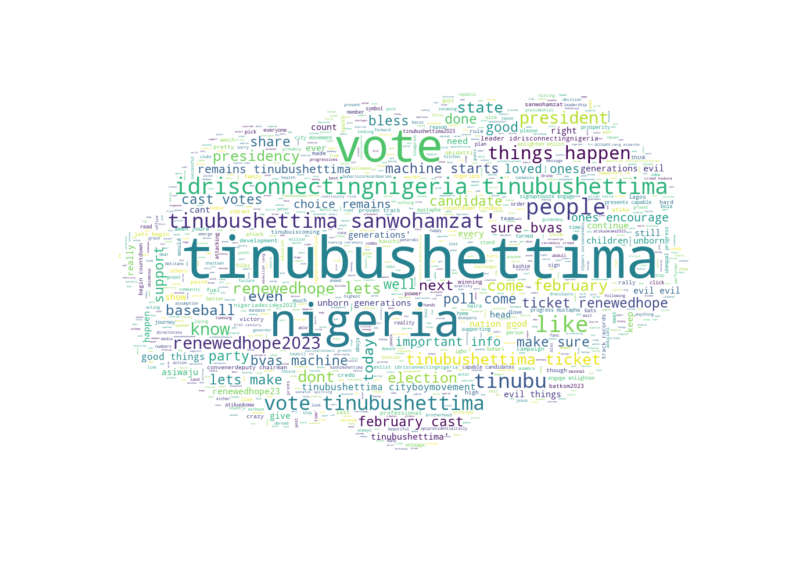

In [106]:
candidate_word_cloud("BAT")

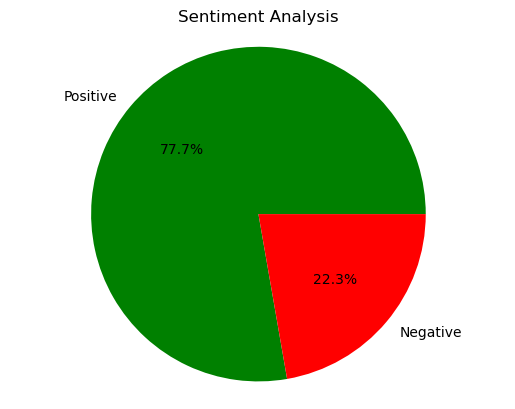

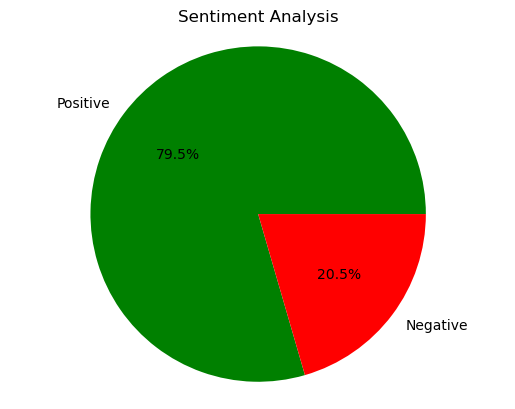

In [91]:
plot_sentiments("BAT")

In [4]:
deb = pd.read_csv("tweet_sample.csv")

In [5]:
deb = deb.drop('Unnamed: 0', axis=1)

In [6]:
deb = list(deb['Raw tweet'])

In [7]:
#clean_text()
a = sentiment_analysis(deb, "obi")

In [8]:
a

,Raw tweet,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,@Oluwamidas6520 @Canny__Dee @PeterObi He said ...,"@peterobi he said ""the agitations in the sout...",0.000000,0.500000,negative,0.106,0.894,0.0,-0.6031
1,Do not vote your conscience it's not good enou...,do not vote your conscience it's not good enou...,0.037500,0.470238,NaN,NaN,NaN,NaN,NaN
2,Funny! A man that has NEVER held any DEFINITIV...,funny! a man that has never held any definitiv...,0.678125,0.925000,NaN,NaN,NaN,NaN,NaN
3,"@itzz_blitz1 @PeterObi Yes, that is fine.","@peterobi yes, that is fine.",0.416667,0.500000,NaN,NaN,NaN,NaN,NaN
4,@SaharaReporters @YeleSowore @officialABAT @at...,"@peterobi nonsense,who sends you?is this all ...",0.320000,0.445000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2000,@stefan_mccauley Dey play o... Who you want ca...,Just keep playing... who you want cajole with...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2001,@gchahal @PeterObi @atiku @officialABAT Peter ...,@peterobi peter obi for president,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2002,@balamiisaac @PeterObi @NgLabour @aburechamber...,@peterobi they try to intimidate peter obi in...,-0.183333,0.108333,NaN,NaN,NaN,NaN,NaN
2003,@balamiisaac @PeterObi @NgLabour @aburechamber...,@peterobi nice to see. obi means well for eve...,0.650000,0.800000,NaN,NaN,NaN,NaN,NaN


In [11]:
a['refined_tweet']=a['text']

### Using Bigrams

In [12]:
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.probability import FreqDist
tw_list = sentiment_analysis(deb, "obi")
stop_words = set(stopwords.words("english"))
stop_words.update(["the", "your", "ur", "want", "what", "wat", "said", "try", "go"])

#remove stopwords
tw_list['text'] = tw_list['text'].str.replace('[{}]'.format(string.punctuation), '')
tw_list['text'] = tw_list['text'].str.replace(r'\b\w{1,3}\b', '')
tw_list['text'] = tw_list['text'].apply(lambda x: [word for word in x.split() if word not in stop_words])


C:\Users\Dee\AppData\Local\Temp/ipykernel_7440/1497698443.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  tw_list['text'] = tw_list['text'].str.replace('[{}]'.format(string.punctuation), '')
C:\Users\Dee\AppData\Local\Temp/ipykernel_7440/1497698443.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  tw_list['text'] = tw_list['text'].str.replace(r'\b\w{1,3}\b', '')


In [13]:
tw_list['text']

0       [peterobi, agitations, south, east, leader, ca...
1       [vote, conscience, good, enough, specific, tak...
2       [funny, never, held, definitive, executive, po...
3                                        [peterobi, fine]
4       [peterobi, nonsensewho, sends, youis, need, go...
                              ...                        
2000    [Just, keep, playing, cajole, games, whatever,...
2001                         [peterobi, peter, president]
2002    [peterobi, intimidate, peter, kastina, state, ...
2003    [peterobi, nice, means, well, every, section, ...
2004                   [peterobi, next, president, blood]
Name: text, Length: 2005, dtype: object

In [14]:
tw_list['text'] = tw_list['text'].apply(lambda x: " ".join(x))
#extract bigrams
#tw_list['bigrams'] = tw_list['text'].apply(lambda x: list(bigrams(x)))
#tokens = nltk.word_tokenize(tw_list['bigrams'].str.cat(sep=' '))
#FreqDist(tw_list['bigrams'])

In [15]:
text_column = tw_list['text']
bigrams_list = [bigrams(row) for row in text_column]

In [16]:
tw_list['text']

0       peterobi agitations south east leader caught p...
1       vote conscience good enough specific take best...
2       funny never held definitive executive position...
3                                           peterobi fine
4       peterobi nonsensewho sends youis need good gov...
                              ...                        
2000    Just keep playing cajole games whatever petero...
2001                             peterobi peter president
2002    peterobi intimidate peter kastina state attack...
2003    peterobi nice means well every section country...
2004                        peterobi next president blood
Name: text, Length: 2005, dtype: object

In [17]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import word_tokenize

# Assume column is called 'text_column' and is a column in a pandas DataFrame
text_list = tw_list['text']#.tolist()

# Tokenize the text into a list of words
tokens = nltk.word_tokenize(text_list.str.cat(sep=' '))
# Create a BigramCollocationFinder
finder = BigramCollocationFinder.from_words(tokens)

# Use the score_ngrams method to count the bigrams
bigram_measures = BigramAssocMeasures()
bigrams = finder.score_ngrams(bigram_measures.raw_freq)

# Print out the bigrams and their counts
for bigram, count in bigrams:
    print(bigram, count)


('peterobi', 'peterobi') 0.006978951482329295
('vote', 'peterobi') 0.004466528948690748
('peterobi', 'amen') 0.003238233487800793
('amen', 'peterobi') 0.0027357489810730835
('labour', 'party') 0.0027357489810730835
('peterobi', 'peter') 0.0027357489810730835
('president', 'peterobi') 0.0026240857573558147
('nigeria', 'peterobi') 0.002065769638769471
('peterobi', 'president') 0.002009938026910837
('peterobi', 'congratulations') 0.0019541064150522024
('peter', 'peterobi') 0.0016191167439003964
('congratulations', 'peterobi') 0.0013399586846072247
('nigeria', 'possible') 0.0012841270727485903
('vote', 'wisely') 0.0012282954608899559
('better', 'nigeria') 0.001060800625314053
('next', 'president') 0.001060800625314053
('peterobi', 'dont') 0.001060800625314053
('peterobi', 'people') 0.001060800625314053
('peterobi', 'like') 0.0010049690134554185
('presidential', 'candidate') 0.0010049690134554185
('peterobi', 'good') 0.0009491374015967841
('peterobi', 'know') 0.0009491374015967841
('rest', 

('come', 'home') 0.00011166322371726871
('come', 'like') 0.00011166322371726871
('come', 'nigh') 0.00011166322371726871
('come', 'twitter') 0.00011166322371726871
('comfort', 'family') 0.00011166322371726871
('coming', 'election') 0.00011166322371726871
('coming', 'president') 0.00011166322371726871
('commander', 'chief') 0.00011166322371726871
('comment', 'peterobi') 0.00011166322371726871
('competence', 'capacity') 0.00011166322371726871
('competence', 'religion') 0.00011166322371726871
('condition', 'parents') 0.00011166322371726871
('confirm', 'peterobi') 0.00011166322371726871
('congratulations', 'brother') 0.00011166322371726871
('congratulations', 'wins') 0.00011166322371726871
('conscience', 'peterobi') 0.00011166322371726871
('contact', 'elite') 0.00011166322371726871
('continent', 'peterobi') 0.00011166322371726871
('continue', 'labour') 0.00011166322371726871
('core', 'northern') 0.00011166322371726871
('corrupt', 'politicians') 0.00011166322371726871
('cost', 'governance') 

('1133am', '829am') 5.583161185863436e-05
('11th', 'february') 5.583161185863436e-05
('1225am', 'labour') 5.583161185863436e-05
('15th', 'june') 5.583161185863436e-05
('1906', 'election') 5.583161185863436e-05
('1960', 'havent') 5.583161185863436e-05
('1960', 'peterobi') 5.583161185863436e-05
('1984', 'peterobi') 5.583161185863436e-05
('1999', 'come') 5.583161185863436e-05
('19th', 'july') 5.583161185863436e-05
('2000', 'liter') 5.583161185863436e-05
('2000', 'peterobi') 5.583161185863436e-05
('2003', '2000') 5.583161185863436e-05
('2006', 'years') 5.583161185863436e-05
('20072014', 'dont') 5.583161185863436e-05
('200m', 'british') 5.583161185863436e-05
('200m', 'million') 5.583161185863436e-05
('200m', 'people') 5.583161185863436e-05
('200mil', 'nigeria') 5.583161185863436e-05
('2011', '2015') 5.583161185863436e-05
('2011', 'subsidy') 5.583161185863436e-05
('2014', 'campaigned') 5.583161185863436e-05
('2014', 'know') 5.583161185863436e-05
('2015', 'fight') 5.583161185863436e-05
('2015

('arindi', 'ator') 5.583161185863436e-05
('arindin', 'opolo') 5.583161185863436e-05
('arise', 'morning') 5.583161185863436e-05
('arise', 'second') 5.583161185863436e-05
('arisetv', 'peterobi') 5.583161185863436e-05
('arms', 'welcome') 5.583161185863436e-05
('army', 'used') 5.583161185863436e-05
('arne', 'worst') 5.583161185863436e-05
('aroba', 'adalu') 5.583161185863436e-05
('around', 'cause') 5.583161185863436e-05
('around', 'keep') 5.583161185863436e-05
('around', 'lets') 5.583161185863436e-05
('around', 'life') 5.583161185863436e-05
('around', 'like') 5.583161185863436e-05
('around', 'political') 5.583161185863436e-05
('around', 'rigging') 5.583161185863436e-05
('arrange', 'roll') 5.583161185863436e-05
('arrention', 'chrisians') 5.583161185863436e-05
('arrested', 'peterobi') 5.583161185863436e-05
('arrested', 'sponsoring') 5.583161185863436e-05
('arresting', 'situation') 5.583161185863436e-05
('arrival', 'dethroned') 5.583161185863436e-05
('arrival', 'nigeria') 5.583161185863436e-05

('bros', 'code') 5.583161185863436e-05
('bros', 'know') 5.583161185863436e-05
('brother', 'dont') 5.583161185863436e-05
('brother', 'ever') 5.583161185863436e-05
('brother', 'fake') 5.583161185863436e-05
('brother', 'heal') 5.583161185863436e-05
('brother', 'hope') 5.583161185863436e-05
('brother', 'kids') 5.583161185863436e-05
('brother', 'opinion') 5.583161185863436e-05
('brother', 'religious') 5.583161185863436e-05
('brother', 'sadly') 5.583161185863436e-05
('brother', 'uncle') 5.583161185863436e-05
('brother', 'word') 5.583161185863436e-05
('brothers', 'humble') 5.583161185863436e-05
('brothersound', 'minds') 5.583161185863436e-05
('brotherwe', 'together') 5.583161185863436e-05
('brought', 'alpha') 5.583161185863436e-05
('brought', 'back') 5.583161185863436e-05
('brought', 'cost') 5.583161185863436e-05
('brought', 'phone') 5.583161185863436e-05
('brutal', 'beheading') 5.583161185863436e-05
('bubu', 'seen') 5.583161185863436e-05
('bucket', 'yesterday') 5.583161185863436e-05
('bucks'

('commensurate', 'families') 5.583161185863436e-05
('comment', 'abeg') 5.583161185863436e-05
('comment', 'confirmed') 5.583161185863436e-05
('comment', 'hundred') 5.583161185863436e-05
('comment', 'might') 5.583161185863436e-05
('comment', 'nation') 5.583161185863436e-05
('comment', 'peter') 5.583161185863436e-05
('comment', 'reply') 5.583161185863436e-05
('comment', 'since') 5.583161185863436e-05
('comment', 'tweet') 5.583161185863436e-05
('comment', 'well') 5.583161185863436e-05
('commented', '1101') 5.583161185863436e-05
('commenting', 'comment') 5.583161185863436e-05
('commenting', 'peterobi') 5.583161185863436e-05
('commenting', 'poll') 5.583161185863436e-05
('commenting', 'still') 5.583161185863436e-05
('comments', 'flowing') 5.583161185863436e-05
('comments', 'youre') 5.583161185863436e-05
('commercial', 'cleaning') 5.583161185863436e-05
('commiserating', 'abia') 5.583161185863436e-05
('commission', 'print') 5.583161185863436e-05
('commit', 'office') 5.583161185863436e-05
('comm

('dead', 'abia') 5.583161185863436e-05
('dead', 'arrival') 5.583161185863436e-05
('dead', 'bodies') 5.583161185863436e-05
('dead', 'country') 5.583161185863436e-05
('dead', 'criminals') 5.583161185863436e-05
('dead', 'rest') 5.583161185863436e-05
('deadline', 'fast') 5.583161185863436e-05
('deaf', 'cant') 5.583161185863436e-05
('deaf', 'look') 5.583161185863436e-05
('deaf', 'people') 5.583161185863436e-05
('deal', 'peterobi') 5.583161185863436e-05
('deal', 'sure') 5.583161185863436e-05
('dealers', 'abeg') 5.583161185863436e-05
('dealing', 'crook') 5.583161185863436e-05
('dealing', 'himusing') 5.583161185863436e-05
('dealings', 'topic') 5.583161185863436e-05
('dear', 'alaba') 5.583161185863436e-05
('dear', 'concerned') 5.583161185863436e-05
('dear', 'everything') 5.583161185863436e-05
('dear', 'eyes') 5.583161185863436e-05
('dear', 'life') 5.583161185863436e-05
('dear', 'lord') 5.583161185863436e-05
('dear', 'obidients') 5.583161185863436e-05
('dear', 'plans') 5.583161185863436e-05
('de

('embrace', 'insults') 5.583161185863436e-05
('embraced', 'saiobi') 5.583161185863436e-05
('emefiele', 'fighting') 5.583161185863436e-05
('emefiele', 'initiated') 5.583161185863436e-05
('emefiele', 'naira') 5.583161185863436e-05
('emefiele', 'obidatti2023') 5.583161185863436e-05
('emefiele', 'reach') 5.583161185863436e-05
('emerge', 'money') 5.583161185863436e-05
('emerge', 'peterobi') 5.583161185863436e-05
('emerge', 'winner') 5.583161185863436e-05
('emergence', 'peter') 5.583161185863436e-05
('emergence', 'structureless') 5.583161185863436e-05
('emerging', 'prime') 5.583161185863436e-05
('emiefele', 'know') 5.583161185863436e-05
('emilofailure', 'peterobi') 5.583161185863436e-05
('emilokan', 'fall') 5.583161185863436e-05
('emilokan', 'saying') 5.583161185863436e-05
('emirs', 'come') 5.583161185863436e-05
('emotional', 'blackmail') 5.583161185863436e-05
('emotional', 'know') 5.583161185863436e-05
('empathy', 'excellency') 5.583161185863436e-05
('empathy', 'goes') 5.583161185863436e-05

('focus', 'selling') 5.583161185863436e-05
('focus', 'serious') 5.583161185863436e-05
('focused', 'nation') 5.583161185863436e-05
('fodder', 'free') 5.583161185863436e-05
('foil', 'still') 5.583161185863436e-05
('foisted', 'buhari') 5.583161185863436e-05
('fold', 'hands') 5.583161185863436e-05
('follow', 'following') 5.583161185863436e-05
('follow', 'however') 5.583161185863436e-05
('follow', 'legalize') 5.583161185863436e-05
('followed', 'already') 5.583161185863436e-05
('followed', 'back') 5.583161185863436e-05
('followed', 'follow') 5.583161185863436e-05
('followed', 'opened') 5.583161185863436e-05
('followed', 'peterobi') 5.583161185863436e-05
('followed', 'siiince') 5.583161185863436e-05
('followers', 'full') 5.583161185863436e-05
('followers', 'intact') 5.583161185863436e-05
('followers', 'ones') 5.583161185863436e-05
('followers', 'sanitization') 5.583161185863436e-05
('following', 'back') 5.583161185863436e-05
('following', 'buharis') 5.583161185863436e-05
('following', 'shouti

('hard', 'make') 5.583161185863436e-05
('hard', 'need') 5.583161185863436e-05
('hard', 'never') 5.583161185863436e-05
('hard', 'truth') 5.583161185863436e-05
('hard', 'validate') 5.583161185863436e-05
('hard', 'working') 5.583161185863436e-05
('hardly', 'mention') 5.583161185863436e-05
('hardship', 'death') 5.583161185863436e-05
('hardship', 'making') 5.583161185863436e-05
('hardship', 'reach') 5.583161185863436e-05
('hardship', 'secondscome') 5.583161185863436e-05
('hardship', 'tell') 5.583161185863436e-05
('hardwork', 'artists') 5.583161185863436e-05
('harsher', 'cane') 5.583161185863436e-05
('hash', 'nigeriastudentsmustvote') 5.583161185863436e-05
('hate', 'biafra') 5.583161185863436e-05
('hate', 'evil') 5.583161185863436e-05
('hate', 'follows') 5.583161185863436e-05
('hate', 'igbos') 5.583161185863436e-05
('hate', 'maker') 5.583161185863436e-05
('hate', 'much') 5.583161185863436e-05
('hate', 'support') 5.583161185863436e-05
('hate', 'truth') 5.583161185863436e-05
('hates', 'north')

('jesus', 'marked') 5.583161185863436e-05
('jesus', 'peterobi') 5.583161185863436e-05
('jiki', 'magayi') 5.583161185863436e-05
('jior', 'fact') 5.583161185863436e-05
('jisie', 'peterobi') 5.583161185863436e-05
('jisike', 'ooowe') 5.583161185863436e-05
('jobless', 'youths') 5.583161185863436e-05
('joblessness', 'nigeria') 5.583161185863436e-05
('jobs', 'allowed') 5.583161185863436e-05
('jobs', 'cordially') 5.583161185863436e-05
('jobs', 'know') 5.583161185863436e-05
('join', 'camp') 5.583161185863436e-05
('join', 'candidates') 5.583161185863436e-05
('join', 'change') 5.583161185863436e-05
('join', 'electoral') 5.583161185863436e-05
('join', 'hand') 5.583161185863436e-05
('join', 'hands') 5.583161185863436e-05
('join', 'labour') 5.583161185863436e-05
('join', 'peter') 5.583161185863436e-05
('join', 'politics') 5.583161185863436e-05
('join', 'protest') 5.583161185863436e-05
('join', 'suffering') 5.583161185863436e-05
('join', 'throw') 5.583161185863436e-05
('join', 'tinubu') 5.58316118586

('list', 'antecedent') 5.583161185863436e-05
('list', 'peterobi') 5.583161185863436e-05
('list', 'zero') 5.583161185863436e-05
('listen', 'boss') 5.583161185863436e-05
('listen', 'full') 5.583161185863436e-05
('listen', 'hitler') 5.583161185863436e-05
('listen', 'nigerians') 5.583161185863436e-05
('listen', 'nothing') 5.583161185863436e-05
('listen', 'people') 5.583161185863436e-05
('listen', 'peterobi') 5.583161185863436e-05
('listen', 'times') 5.583161185863436e-05
('listened', 'care') 5.583161185863436e-05
('listened', 'yanzu') 5.583161185863436e-05
('listening', 'interview') 5.583161185863436e-05
('listening', 'wisdom') 5.583161185863436e-05
('liter', 'peterobi') 5.583161185863436e-05
('liter', 'rice') 5.583161185863436e-05
('literal', 'meaning') 5.583161185863436e-05
('literally', 'peterobi') 5.583161185863436e-05
('literally', 'withhold') 5.583161185863436e-05
('litre', 'banks') 5.583161185863436e-05
('litre', 'makaryacin') 5.583161185863436e-05
('litre', 'market') 5.583161185863

('muslims', 'vote') 5.583161185863436e-05
('must', 'achieved') 5.583161185863436e-05
('must', 'bangladesh') 5.583161185863436e-05
('must', 'biasness') 5.583161185863436e-05
('must', 'brought') 5.583161185863436e-05
('must', 'chose') 5.583161185863436e-05
('must', 'collect') 5.583161185863436e-05
('must', 'dayif') 5.583161185863436e-05
('must', 'debt') 5.583161185863436e-05
('must', 'double') 5.583161185863436e-05
('must', 'fail') 5.583161185863436e-05
('must', 'good') 5.583161185863436e-05
('must', 'governance') 5.583161185863436e-05
('must', 'great') 5.583161185863436e-05
('must', 'hesitate') 5.583161185863436e-05
('must', 'high') 5.583161185863436e-05
('must', 'increase') 5.583161185863436e-05
('must', 'ipob') 5.583161185863436e-05
('must', 'look') 5.583161185863436e-05
('must', 'next') 5.583161185863436e-05
('must', 'pounding') 5.583161185863436e-05
('must', 'presidential') 5.583161185863436e-05
('must', 'shift') 5.583161185863436e-05
('must', 'step') 5.583161185863436e-05
('must', 

('norther', 'peterobi') 5.583161185863436e-05
('northern', 'christians') 5.583161185863436e-05
('northern', 'dont') 5.583161185863436e-05
('northern', 'education') 5.583161185863436e-05
('northern', 'nigeria') 5.583161185863436e-05
('northern', 'part') 5.583161185863436e-05
('northern', 'people') 5.583161185863436e-05
('northern', 'presidential') 5.583161185863436e-05
('northern', 'space') 5.583161185863436e-05
('northern', 'states') 5.583161185863436e-05
('northern', 'wild') 5.583161185863436e-05
('northern', 'women') 5.583161185863436e-05
('northern', 'youths') 5.583161185863436e-05
('northerner', 'transformed') 5.583161185863436e-05
('northerners', 'carry') 5.583161185863436e-05
('northerners', 'first') 5.583161185863436e-05
('northerners', 'love') 5.583161185863436e-05
('northerns', 'voted') 5.583161185863436e-05
('not', 'assertion') 5.583161185863436e-05
('not', 'escape') 5.583161185863436e-05
('not', 'exist') 5.583161185863436e-05
('not', 'fake') 5.583161185863436e-05
('not', 'id

('people', 'power') 5.583161185863436e-05
('people', 'presidential') 5.583161185863436e-05
('people', 'prophecies') 5.583161185863436e-05
('people', 'proud') 5.583161185863436e-05
('people', 'pvcs') 5.583161185863436e-05
('people', 'questioned') 5.583161185863436e-05
('people', 'rate') 5.583161185863436e-05
('people', 'ready') 5.583161185863436e-05
('people', 'reducing') 5.583161185863436e-05
('people', 'remember') 5.583161185863436e-05
('people', 'save') 5.583161185863436e-05
('people', 'seem') 5.583161185863436e-05
('people', 'siding') 5.583161185863436e-05
('people', 'since') 5.583161185863436e-05
('people', 'sold') 5.583161185863436e-05
('people', 'still') 5.583161185863436e-05
('people', 'stoopid') 5.583161185863436e-05
('people', 'talk') 5.583161185863436e-05
('people', 'tell') 5.583161185863436e-05
('people', 'thank') 5.583161185863436e-05
('people', 'think') 5.583161185863436e-05
('people', 'threatened') 5.583161185863436e-05
('people', 'tired') 5.583161185863436e-05
('people',

('peterobi', 'sabotaging') 5.583161185863436e-05
('peterobi', 'safety') 5.583161185863436e-05
('peterobi', 'sake') 5.583161185863436e-05
('peterobi', 'salvage') 5.583161185863436e-05
('peterobi', 'sane') 5.583161185863436e-05
('peterobi', 'sarcastic') 5.583161185863436e-05
('peterobi', 'savage') 5.583161185863436e-05
('peterobi', 'saying') 5.583161185863436e-05
('peterobi', 'scammer') 5.583161185863436e-05
('peterobi', 'scammers') 5.583161185863436e-05
('peterobi', 'school') 5.583161185863436e-05
('peterobi', 'seal') 5.583161185863436e-05
('peterobi', 'secondary') 5.583161185863436e-05
('peterobi', 'secure') 5.583161185863436e-05
('peterobi', 'seeing') 5.583161185863436e-05
('peterobi', 'seek') 5.583161185863436e-05
('peterobi', 'seen') 5.583161185863436e-05
('peterobi', 'self') 5.583161185863436e-05
('peterobi', 'seyi') 5.583161185863436e-05
('peterobi', 'share') 5.583161185863436e-05
('peterobi', 'sharp') 5.583161185863436e-05
('peterobi', 'shebi') 5.583161185863436e-05
('peterobi', 

('principal', 'lives') 5.583161185863436e-05
('principal', 'plans') 5.583161185863436e-05
('principal', 'records') 5.583161185863436e-05
('principal', 'tinubu') 5.583161185863436e-05
('principled', 'kind') 5.583161185863436e-05
('print', 'anyone') 5.583161185863436e-05
('print', 'forget') 5.583161185863436e-05
('print', 'peterobi') 5.583161185863436e-05
('prior', '2015') 5.583161185863436e-05
('prioritise', 'feeble') 5.583161185863436e-05
('prioritised', 'anambra') 5.583161185863436e-05
('private', 'island') 5.583161185863436e-05
('private', 'public') 5.583161185863436e-05
('probe', 'criminal') 5.583161185863436e-05
('probe', 'tinubu') 5.583161185863436e-05
('problem', 'avoid') 5.583161185863436e-05
('problem', 'bats') 5.583161185863436e-05
('problem', 'feel') 5.583161185863436e-05
('problem', 'make') 5.583161185863436e-05
('problem', 'neither') 5.583161185863436e-05
('problem', 'nigeria') 5.583161185863436e-05
('problem', 'people') 5.583161185863436e-05
('problem', 'shouldnt') 5.58316

('sabi', 'catch') 5.583161185863436e-05
('sabinus', 'voice') 5.583161185863436e-05
('sabmiller', 'make') 5.583161185863436e-05
('sabotage', 'brother') 5.583161185863436e-05
('sabotage', 'chances') 5.583161185863436e-05
('sabotage', 'insecurity') 5.583161185863436e-05
('sabotage', 'like') 5.583161185863436e-05
('sabotage', 'lives') 5.583161185863436e-05
('sabotaging', 'election') 5.583161185863436e-05
('sabotaging', 'electricity') 5.583161185863436e-05
('sabotaging', 'failure') 5.583161185863436e-05
('sacrifice', '3days') 5.583161185863436e-05
('sacrifice', 'right') 5.583161185863436e-05
('sacrificed', 'presidential') 5.583161185863436e-05
('sacrifices', 'move') 5.583161185863436e-05
('sacrifices', 'team') 5.583161185863436e-05
('sadly', 'can') 5.583161185863436e-05
('sadly', 'election') 5.583161185863436e-05
('safe', 'dear') 5.583161185863436e-05
('safe', 'hope') 5.583161185863436e-05
('safe', 'livable') 5.583161185863436e-05
('safe', 'peterobi') 5.583161185863436e-05
('safely', 'every

('southern', 'part') 5.583161185863436e-05
('southern', 'politics') 5.583161185863436e-05
('southern', 'presidenti') 5.583161185863436e-05
('southernborno', 'peterobi') 5.583161185863436e-05
('southerners', 'believe') 5.583161185863436e-05
('southerners', 'self') 5.583161185863436e-05
('sowore', 'followers') 5.583161185863436e-05
('sowore', 'know') 5.583161185863436e-05
('sowore', 'media') 5.583161185863436e-05
('sowore', 'political') 5.583161185863436e-05
('sowore', 'rest') 5.583161185863436e-05
('space', 'matter') 5.583161185863436e-05
('space', 'thus') 5.583161185863436e-05
('spaces', 'massive') 5.583161185863436e-05
('spaces', 'peterobi') 5.583161185863436e-05
('spare', 'naysayers') 5.583161185863436e-05
('spare', 'tyre') 5.583161185863436e-05
('speak', 'abeg') 5.583161185863436e-05
('speak', 'amashorire') 5.583161185863436e-05
('speak', 'better') 5.583161185863436e-05
('speak', 'brother') 5.583161185863436e-05
('speak', 'english') 5.583161185863436e-05
('speak', 'everyman') 5.5831

('talk', 'trashuncle') 5.583161185863436e-05
('talk', 'true') 5.583161185863436e-05
('talking', 'candidate') 5.583161185863436e-05
('talking', 'changes') 5.583161185863436e-05
('talking', 'criminal') 5.583161185863436e-05
('talking', 'failed') 5.583161185863436e-05
('talking', 'friend') 5.583161185863436e-05
('talking', 'himhe') 5.583161185863436e-05
('talking', 'nonsense') 5.583161185863436e-05
('talking', 'plans') 5.583161185863436e-05
('talking', 'politics') 5.583161185863436e-05
('talking', 'think') 5.583161185863436e-05
('talking', 'weed') 5.583161185863436e-05
('talkless', 'peterobi') 5.583161185863436e-05
('talks', 'anyhow') 5.583161185863436e-05
('talks', 'never') 5.583161185863436e-05
('tame', 'bigotry') 5.583161185863436e-05
('tank', 'even') 5.583161185863436e-05
('tanko', 'yunusa') 5.583161185863436e-05
('tantrums', 'buhari') 5.583161185863436e-05
('tantrums', 'funny') 5.583161185863436e-05
('tantrums', 'making') 5.583161185863436e-05
('tarred', 'express') 5.583161185863436e

('upon', 'continue') 5.583161185863436e-05
('upon', 'delivery') 5.583161185863436e-05
('upon', 'gentle') 5.583161185863436e-05
('upon', 'spare') 5.583161185863436e-05
('uppercut', 'obidattiingombe') 5.583161185863436e-05
('upright', 'nigerian') 5.583161185863436e-05
('upstairs', 'wrong') 5.583161185863436e-05
('upward', 'gombe') 5.583161185863436e-05
('urcandidate', 'abnormal') 5.583161185863436e-05
('urchin', 'accuse') 5.583161185863436e-05
('urchins', 'must') 5.583161185863436e-05
('urgent', 'sensitization') 5.583161185863436e-05
('urine', 'stained') 5.583161185863436e-05
('used', 'cant') 5.583161185863436e-05
('used', 'secure') 5.583161185863436e-05
('used', 'votes') 5.583161185863436e-05
('useless', 'calendar') 5.583161185863436e-05
('useless', 'candidatekoni') 5.583161185863436e-05
('useless', 'consumption') 5.583161185863436e-05
('useless', 'obidiots') 5.583161185863436e-05
('useless', 'party') 5.583161185863436e-05
('useless', 'peterobi') 5.583161185863436e-05
('usher', 'incomin

('whenever', 'remembers') 5.583161185863436e-05
('whenever', 'speaks') 5.583161185863436e-05
('wherever', 'peterobi') 5.583161185863436e-05
('whether', 'babalola') 5.583161185863436e-05
('whether', 'ballot') 5.583161185863436e-05
('whichever', 'look') 5.583161185863436e-05
('whichever', 'party') 5.583161185863436e-05
('whiles', 'remain') 5.583161185863436e-05
('whin', 'politicians') 5.583161185863436e-05
('whip', 'harsher') 5.583161185863436e-05
('white', 'black') 5.583161185863436e-05
('whoever', 'like') 5.583161185863436e-05
('whoever', 'wants') 5.583161185863436e-05
('whoever', 'whichever') 5.583161185863436e-05
('whoever', 'wins') 5.583161185863436e-05
('whole', 'camp') 5.583161185863436e-05
('whole', 'done') 5.583161185863436e-05
('whole', 'game') 5.583161185863436e-05
('whole', 'northern') 5.583161185863436e-05
('whole', 'would') 5.583161185863436e-05
('whomever', 'choose') 5.583161185863436e-05
('whos', 'shldnt') 5.583161185863436e-05
('whos', 'speaking') 5.583161185863436e-05
(

### Using Monograms

In [18]:
import nltk
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
tw_list = sentiment_analysis(deb, "obi")
# Define your column of text
text_column = tw_list['text']
tw_list['text'] = tw_list['text'].str.replace('[{}]'.format(string.punctuation), '')
text_column = tw_list['text'].str.replace(r'\b\w{1,3}\b', '')


# Tokenize the text
tokens = nltk.word_tokenize(text_column.str.cat(sep=' '))

# Remove stop words
stop_words = set(stopwords.words('english'))
stop_words.update(["the", "your", "ur", "want", "what", "wat", "said", "try", "go"])
tokens = [word for word in tokens if word.lower() not in stop_words]

# Create a frequency distribution
fdist = FreqDist(tokens)

# Print the top n most common words
n = 100
print(fdist.most_common(n))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('peterobi', 1988), ('vote', 254), ('nigeria', 229), ('people', 168), ('peter', 155), ('president', 152), ('like', 130), ('know', 100), ('party', 97), ('election', 87), ('state', 87), ('dont', 85), ('good', 84), ('please', 80), ('amen', 80), ('tinubu', 79), ('nigerians', 79), ('better', 77), ('make', 71), ('time', 70), ('candidate', 65), ('labour', 58), ('even', 54), ('come', 54), ('country', 50), ('atiku', 50), ('congratulations', 48), ('still', 45), ('next', 45), ('need', 44), ('campaign', 44), ('love', 44), ('tell', 44), ('north', 44), ('presidential', 43), ('right', 43), ('never', 41), ('bless', 41), ('cant', 41), ('coming', 40), ('must', 40), ('support', 40), ('thank', 39), ('buhari', 39), ('voting', 38), ('well', 38), ('rest', 37), ('take', 36), ('hope', 36), ('stop', 36), ('person', 34), ('family', 34), ('sure', 34), ('massive', 34), ('lagos', 34), ('money', 34), ('south', 33), ('youre', 33), ('possible', 32), ('back', 31), ('work', 31), ('fuel', 30), ('going', 30), ('borno', 3

C:\Users\Dee\AppData\Local\Temp/ipykernel_7440/2518452221.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  tw_list['text'] = tw_list['text'].str.replace('[{}]'.format(string.punctuation), '')
C:\Users\Dee\AppData\Local\Temp/ipykernel_7440/2518452221.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  text_column = tw_list['text'].str.replace(r'\b\w{1,3}\b', '')


### Sentiment Analysis

In [23]:
df = clean_text(deb, 'obi')

In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# Iterate through each text in the column
for text in tw_list['text']:
    # Use the polarity_scores method to get the sentiment scores
    sentiment_scores = sia.polarity_scores(text)
    # Extract the compound score, which ranges from -1 to 1
    # and represents the overall sentiment of the text
    compound_score = sentiment_scores['compound']
    # Print the compound score for each text
    print(compound_score)

-0.6031
-0.8911
0.2732
0.5423
0.1531
0.5994
0.5423
0.4019
0.0
0.5267
-0.8557
-0.2263
0.4404
-0.6497
0.0
0.0
0.6369
-0.5719
-0.6497
0.5423
0.0
0.0
0.6369
0.0
0.6124
0.4404
0.1779
0.886
0.4754
-0.0516
0.8271
-0.7845
0.4939
0.0
0.7447
-0.8934
0.0
0.2023
0.0
0.5719
0.4019
-0.5423
0.4019
0.7269
0.3612
-0.7269
0.9118
0.8689
0.4215
0.5994
0.3818
0.0
0.5994
-0.7717
0.5267
0.0
-0.3182
-0.25
-0.5466
-0.3818
0.5106
0.0194
0.3612
0.1531
0.5994
0.0
-0.3818
-0.1531
0.5994
0.0
0.5773
0.3612
0.0516
0.4404
-0.4767
0.4567
0.0
0.6249
0.2263
0.928
0.5994
-0.1808
0.7096
0.0387
0.34
-0.0516
-0.8207
0.5615
0.0
0.0
-0.1779
-0.4678
0.8402
0.0
0.7096
0.34
0.0
0.0
-0.4404
0.0
0.0
0.34
0.0
0.0
0.2263
-0.2732
0.0772
-0.5875
0.2732
0.926
0.6908
0.3724
0.0
0.6369
0.7096
-0.5574
0.9052
-0.2975
0.0654
-0.4767
0.5423
-0.2732
0.0
0.6486
0.9493
0.4588
0.6705
0.2732
0.7096
0.8508
0.2052
0.5574
0.296
0.9061
0.0
0.0
0.6124
-0.7974
-0.128
0.0
0.2732
-0.296
0.0
0.5859
-0.7096
0.8271
0.1779
0.6288
-0.4545
-0.4767
0.0
0.6369
0.

-0.296
0.8074
0.5423
0.6542
-0.6124
0.5719
0.8658
-0.5574
0.802
0.5106
0.0
0.0
0.6369
0.2732
-0.2023
0.0
0.2732
0.796
0.8562
0.7845
0.0
0.4939
0.7108
0.5994
0.8779
0.0
0.4019
0.0
0.5106
0.0
0.3612
0.222
0.5574
0.0
0.0
0.0
0.0
0.4215
0.3818
0.7351
0.743
0.4939
0.0
-0.4767
0.0
0.6369
0.0
0.0
-0.5106
-0.296
0.0
0.4767
-0.7003
0.0516
-0.4019
0.0
-0.0634
0.0323
0.0516
-0.5267
0.3182
0.8402
-0.9201
-0.296
0.6486
0.8555
0.4215
0.0
0.4767
-0.296
0.0
0.2263
0.3818
0.0
0.0
0.498
-0.9153
-0.4019
0.128
0.0772
0.0
0.0
0.395
-0.6908
0.128
0.0
0.4215
0.5994
-0.5574
-0.6124
0.3612
0.0
0.09
0.2144
0.0
0.7269
0.7783
-0.6486
0.0
0.0
-0.3612
-0.765
-0.9377
0.7151
-0.5574
0.4019
0.4767
0.6808
0.6059
-0.296
0.0
-0.7963
0.1027
0.5859
0.0
-0.5106
-0.25
0.0
0.4588
0.1027
0.0
0.5574
0.4939
0.4767
-0.296
0.1027
0.4404
0.2732
-0.5719
0.8779
0.0
0.0
0.5994
-0.296
0.0
0.8779
0.8176
0.0
-0.7675
0.0
-0.3565
0.7506
0.836
0.6369
0.868
-0.6486
0.2579
-0.9081
-0.688
0.0772
0.0
0.0258
0.5531
0.0
0.8176
-0.4588
0.0772
-0.5

In [29]:
df

,Raw tweet,text,sentiment,neg,neu,pos,compound
0,@Oluwamidas6520 @Canny__Dee @PeterObi He said ...,"@peterobi he said ""the agitations in the sout...","{'neg': 0.106, 'neu': 0.894, 'pos': 0.0, 'comp...",0.106,0.894,0.000,-0.6031
1,Do not vote your conscience it's not good enou...,do not vote your conscience it's not good enou...,"{'neg': 0.275, 'neu': 0.657, 'pos': 0.067, 'co...",0.275,0.657,0.067,-0.8993
2,Funny! A man that has NEVER held any DEFINITIV...,funny! a man that has never held any definitiv...,"{'neg': 0.047, 'neu': 0.869, 'pos': 0.084, 'co...",0.047,0.869,0.084,0.3382
3,"@itzz_blitz1 @PeterObi Yes, that is fine.","@peterobi yes, that is fine.","{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound...",0.000,0.400,0.600,0.5423
4,@SaharaReporters @YeleSowore @officialABAT @at...,"@peterobi nonsense,who sends you?is this all ...","{'neg': 0.029, 'neu': 0.904, 'pos': 0.068, 'co...",0.029,0.904,0.068,0.2824
...,...,...,...,...,...,...,...
2000,@stefan_mccauley Dey play o... Who you want ca...,Just keep playing... who you want cajole with...,"{'neg': 0.0, 'neu': 0.933, 'pos': 0.067, 'comp...",0.000,0.933,0.067,0.1511
2001,@gchahal @PeterObi @atiku @officialABAT Peter ...,@peterobi peter obi for president,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2002,@balamiisaac @PeterObi @NgLabour @aburechamber...,@peterobi they try to intimidate peter obi in...,"{'neg': 0.351, 'neu': 0.558, 'pos': 0.091, 'co...",0.351,0.558,0.091,-0.9460
2003,@balamiisaac @PeterObi @NgLabour @aburechamber...,@peterobi nice to see. obi means well for eve...,"{'neg': 0.0, 'neu': 0.593, 'pos': 0.407, 'comp...",0.000,0.593,0.407,0.8519


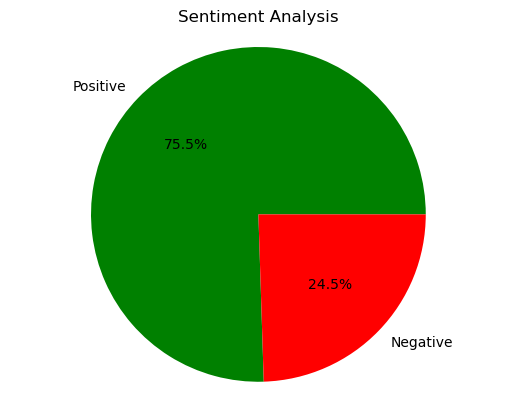

In [32]:
import matplotlib.pyplot as plt
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0 else 'negative')

# count the number of positive and negative sentiments
pos_count = df[df['sentiment'] == 'positive']['sentiment'].count()
neg_count = df[df['sentiment'] == 'negative']['sentiment'].count()

# create the pie chart
labels = ['Positive', 'Negative']
sizes = [pos_count, neg_count]
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Sentiment Analysis')
plt.show()
